   ## TP 1 - Algorithmes de descente en optimisation différentiable

Dans ce TP, nous allons nous intéresser aux algorithmes les plus classiques de minimisation sans contrainte: algorithmes de descente de gradient, algorithmes de type Newton.

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib notebook

Le but de cette séance est l'écriture d'un code de minimisation locale et l'évaluation de des performances sur les fonctions tests suivantes:
$$f_1(x,y) = \frac{1}{2}x^2+\frac{7}{2}y^2.$$
$$f_2(x,y) = \frac{1}{2}x^2+x \cos y.$$
$$f_3(x,y) = 100(y-x^2)^2 + (1-x)^2.$$


In [ ]:
# Fonctions tests
def f1(x):
    A=np.array([[1,0],[0,7]])
    f=1/2*(np.dot(x.transpose(),np.dot(A,x)))
    df=np.dot(A,x)
    Hf=A
    return f,df,Hf
  
def f2(x) :
    f=1/2*x[0]**2 +x[0]*np.cos(x[1])
    df=np.array([x[0] + np.cos(x[1]), -x[0] * np.sin(x[1])])
    Hf = np.matrix([[1,-np.sin(x[1])], [-np.sin(x[1]), -x[0]*np.cos(x[1])]])
    return f,df,Hf

def f3(x) :
    f = 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2
    dfdx = 400 * (x[0]**3 - x[1] * x[0]) + 2 * (x[0] - 1)
    dfdy = 200 * (x[1] - x[0]**2)
    df = np.array([dfdx, dfdy])
    Hf = np.array([[1200 * x[0]**2 - 400 * x[1] + 2, -400 * x[0]],
                    [-400 * x[0], 200]])
    return f,df,Hf

### 1. Algorithmes de descente de gradient

Dans cette première partie, nous allons implémenter des algorithmes de descente de gradient:
$$x_{k+1} = x_k - s_k\nabla f(x_k),$$
où $s_k>0$ désigne le pas calculé par différentes stratégies de recherche linéaires.

#### 1.1. Pas constant
La fonction de recherche linéaire ls_constant qui réalise un pas fixe vous est donnée ci-après. Tester l'algorithme de descente de gradient à pas fixe pour différentes valeurs du pas et observer numériquement que lorsque le pas est trop grand ou trop petit, l'algorithme peut diverger.

1. Implémenter une fonction qui dc_gradient qui renvoie la direction de descente 

In [ ]:
def dc_gradient(x,function,nb_computation) :
    f,df,Hf = function(x)
    nb_computation[1]+=1
    return -df

La fonction ls_constant donnée ci-après est un algorithme de recherche linéaire à pas fixe

In [ ]:
def ls_constant(x,function,step,descent,nb_computation) :
    return step

2. Implémenter une fonction de recherche linéaire ls_backtracking qui calcule un pas par rebroussement. 

In [ ]:
def ls_non_increasing(x,function,step,descent,nb_computation) :
    f,df,Hf = function(x)
    fnew,dfnew,Hfnew=function(x+step*descent)
    nb_computation[0]+=2
    while fnew>f:
        step =step/2
        fnew,dfnew,Hfnew = function(x+step*descent)
    return step
    

3. Implémenter une fonction de recherche linéaire ls_partial_linesearch qui calcule le pas $s_{k+1}$ parmi $\{0.1 s_k,0.5s_k,s_k,2s_k,10s_k\}$ qui minimise $f(x_k+sd_k)$.

In [ ]:
def ls_partial_linesearch(x,function,step,descent,nb_computation) :
    vector = np.array([0.1, 0.5, 1, 2, 10])
    f_values = np.array([function(x + step * i * x)[0] for i in vector])
    nb_computation[0] += len(vector)
    return step * vector[np.argmin(f_values)]

4. On rappelle les conditions de Wolfe:
$$f(x_k +s~d_k) \leq f(x_k) + \varepsilon_1 s\left(\nabla f(x_k)^\top d_k\right),$\hspace{1cm}$\nabla f(x_k+s d_k)^\top d_k \geq \varepsilon_2\left(\nabla f(x_k)^\top d_k\right).$$
avec, en pratique: $\varepsilon_1 = 10^{-4}$ et $\varepsilon_2=0.9$. Implémenter une fonction ls_wolfe.

In [ ]:
def ls_wolfe(x,function,step,descent,nb_computation) :
    e1, e2 = 1e-4, 0.99
    k, s, s_inf, s_sup, d = 0, step, 0, np.inf, descent
    f_x, df_x, Hf = function(x)
    f_xplus_sd, df_xplus_sd, Hf = function(x + s * d)
    nb_computation[0] += 2
    nb_computation[1] += 2
    cd1_OK = f_xplus_sd <= f_x + e1 * s * df_x.dot(d)
    cd2_OK = df_xplus_sd.dot(d) >= e2 * df_x.dot(d)    
    while not(cd1_OK and cd2_OK):
        if not cd1_OK:
            s_sup = s
            s = 0.5 * (s_inf + s_sup)
            f_xplus_sd, df_xplus_sd, Hf = function(x + s * d)
            cd1_OK = f_xplus_sd <= f_x + e1 * s * df_x.dot(d)
            nb_computation[0] += 1
        else:
            s_inf = s
            s = 2 * s if (s_sup == np.inf) else 0.5 * (s_inf + s_sup)
            f_xplus_sd, df_xplus_sd, Hf = function(x + s * d)
            cd2_OK = df_xplus_sd.dot(d) >= e2 * df_x.dot(d)
            nb_computation[1] += 1
        k +=1
    return s

5. Tester les différentes stratégies de recherche linéaire sur les trois exemples proposés à l'aide de l'algorithme de descente à compléter ci-après

In [ ]:
def main_algorithm(function,step=3e-3,xini=np.array([-1,1.2]),ls=ls_constant,dc=dc_gradient):
    x = xini
    x_iter=[]
    step_iter=[]
    f_iter=[]
    eps = 1e-4
    itermax = 20000
    err = 2*eps
    iter = 0
    nb_computation=np.array([0,0,0])
    
    f,df,Hf=function(x)
    #print('iteration :',iter,'f :',f,' df :',np.linalg.norm(df))
    while err>eps and iter<itermax:
        descent=dc(x,function,nb_computation)
        step=ls(x,function,step,descent,nb_computation)
        x = x + step*descent    
        f,df,Hf=function(x)
        x_iter.append(x)
        step_iter.append(step)
        f_iter.append(f)
        err = np.linalg.norm(df)
        iter += 1
        #print('iteration :',iter,'f :',f,' df :',np.linalg.norm(df),'nb_computation :',nb_computation)
    return np.array(x_iter),np.array(step_iter),np.array(f_iter),nb_computation

In [ ]:
def contour_and_f_plot(xiter, fiter, f, levels=None):
    plt.clf()
    Nx = 1000
    Ny = 1000
    x = np.linspace(-2,2,Nx)
    y = np.linspace(-2,2,Ny)
    X, Y = np.meshgrid(x, y)
    Z = [f(np.array([i, j]))[0] for (i,j) in zip(np.nditer(X), np.nditer(Y))]
    Z = np.reshape(Z, X.shape)
    fig, axarr = plt.subplots(1, 2, figsize=(16,8))
    if levels:
        CS = axarr[0].contour(X, Y, Z, levels)
    else:
        CS = axarr[0].contour(X, Y, Z)
    axarr[0].plot(xiter[:,0], xiter[:,1],'r*--')
    axarr[0].clabel(CS, inline=1, fontsize=10)
    if min(fiter) > 0:
        axarr[1].plot(np.log(fiter))
    else:
        axarr[1].plot(fiter)
    plt.show()


<Figure size 432x288 with 0 Axes>

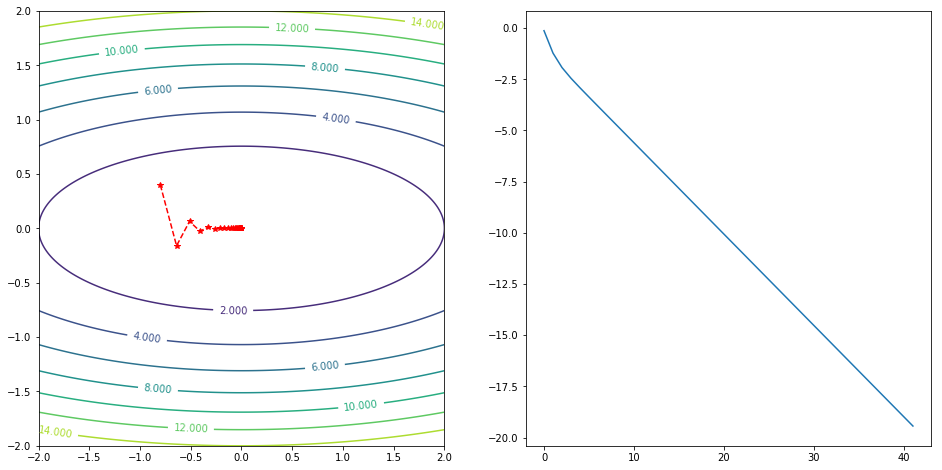

In [ ]:
# Test des différents algorithmes de gradient pour la fonction f1
xiter,stepiter,fiter,nb_comp=main_algorithm(f1,step=0.2,xini=np.array([-1,-1]),ls=ls_wolfe)

#Nx = 1000
#Ny = 1000
#x = np.linspace(-2,2,Nx)
#y = np.linspace(-2,2,Ny)
#X, Y = np.meshgrid(x, y)
#Z=1/2*X**2+7/2*Y**2
#f,axarr = plt.subplots(1, 2)
#CS=axarr[0].contour(X, Y, Z,[0,0.1,0.3,0.5,1,1.5,2,2.5,3,3.5,4])
#axarr[0].plot(xiter[:,0], xiter[:,1])
#axarr[0].clabel(CS, inline=0, fontsize=10)
#axarr[1].plot(np.log(fiter))
#plt.show()

contour_and_f_plot(xiter,fiter, f1)

<Figure size 432x288 with 0 Axes>

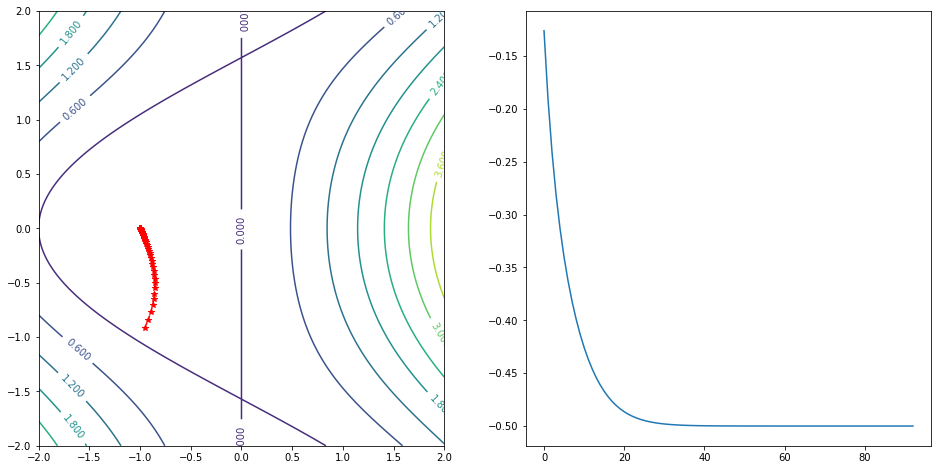

In [ ]:
# Test des différents algorithmes de gradient pour la fonction f2
xiter,stepiter,fiter,nb_comp=main_algorithm(f2,step=0.1,xini=np.array([-1,-1]),ls=ls_wolfe)
contour_and_f_plot(xiter,fiter, f2)

<Figure size 432x288 with 0 Axes>

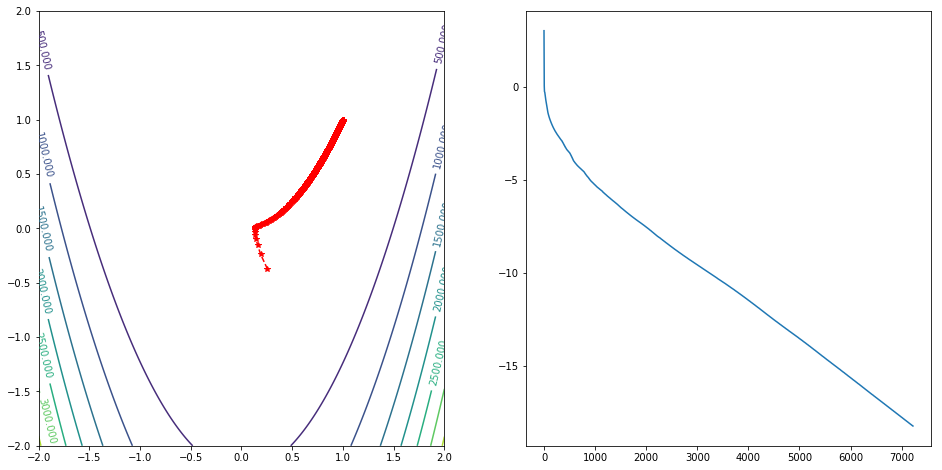

In [ ]:
# Test des différents algorithmes de gradient pour la fonction f3
xiter,stepiter,fiter,nb_comp=main_algorithm(f3,step=0.1,xini=np.array([-1,-1]),ls=ls_wolfe)
contour_and_f_plot(xiter,fiter, f3)

### 2. Algorithme de Newton
Dans cette deuxième partie, nous allons implémenter les algorithmes de Newton classique et avec recherche linéaire:
$$x_{k+1} = x_k - s_kH_f(x_k)^{-1}\nabla f(x_k),$$

Implémenter la méthode de Newton classique et la tester sur les fonctions $f_i$, $i=1,2,3$.

In [ ]:
def dc_Newton(x,function,nb_computation) :
    f, df, Hf = function(x)
    nb_computation[1]+=1
    nb_computation[2]+=1
    return np.linalg.solve(Hf, -df)

<Figure size 432x288 with 0 Axes>

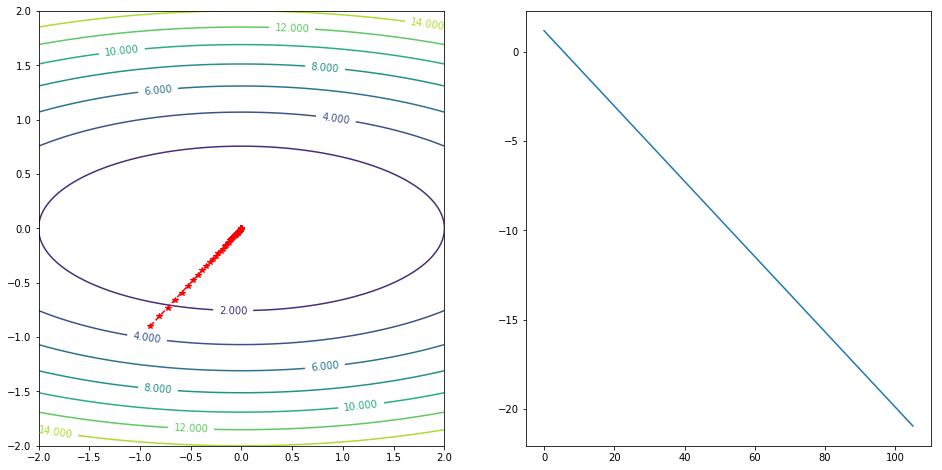

In [ ]:
# Tests
xiter,stepiter,fiter,nb_comp=main_algorithm(f1,step=0.1,xini=np.array([-1,-1]), 
                                            ls=ls_constant, dc=dc_Newton)
contour_and_f_plot(xiter,fiter, f1)

<Figure size 432x288 with 0 Axes>

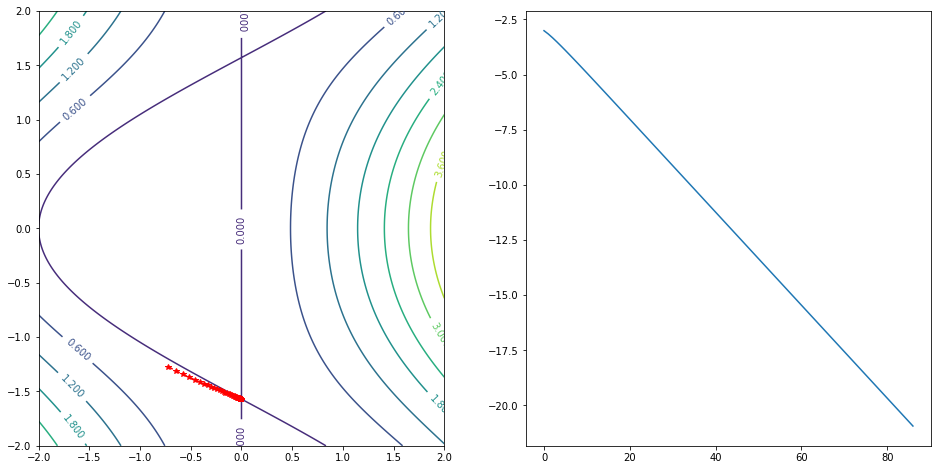

In [ ]:
xiter,stepiter,fiter,nb_comp=main_algorithm(f2,step=0.1,xini=np.array([-1,-1]), 
                                            ls=ls_constant, dc=dc_Newton)
contour_and_f_plot(xiter,fiter, f2)

<Figure size 432x288 with 0 Axes>

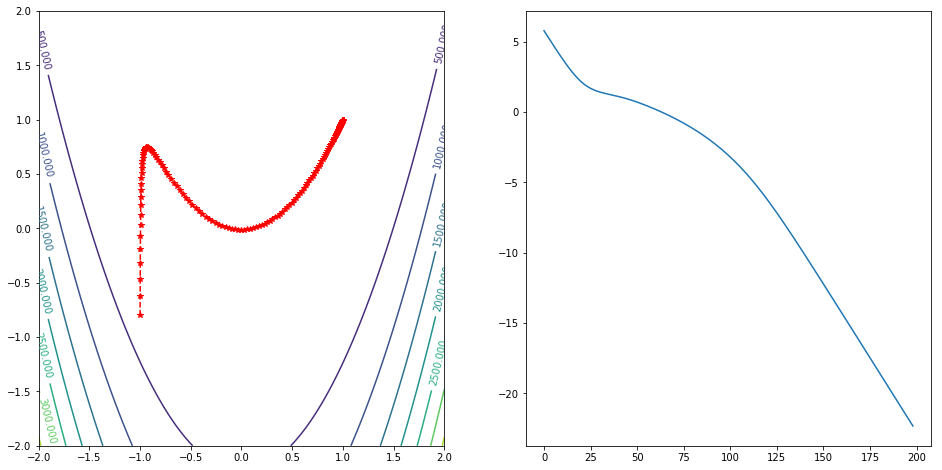

In [ ]:
xiter,stepiter,fiter,nb_comp=main_algorithm(f3,step=0.1,xini=np.array([-1,-1]), 
                                            ls=ls_constant, dc=dc_Newton)
contour_and_f_plot(xiter,fiter, f3)